
### Radial Velocity computation, with pre-calibrated files

Cleaned version with main functions moved into radial_velocity_functions.py

In this file I will work with the precalibrated spectra data from EXPRES given to me by Lily Zhao.


### Imports

In [177]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [ ]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import calibration_functions
importlib.reload(calibration_functions)
from calibration_functions import *

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from os import walk

### Look at the dates of the files

In [ ]:
filenames = get_all_spectra_filenames()
dates = get_spectra_dates(filenames)
print(len(dates), "files found")

plt.figure(figsize=(25, 8))
for index, date in enumerate(dates):
    year, month, date = date
    d = datetime(year, month, date)
    plt.scatter(d, index, color="k", s=2)

### First look at data

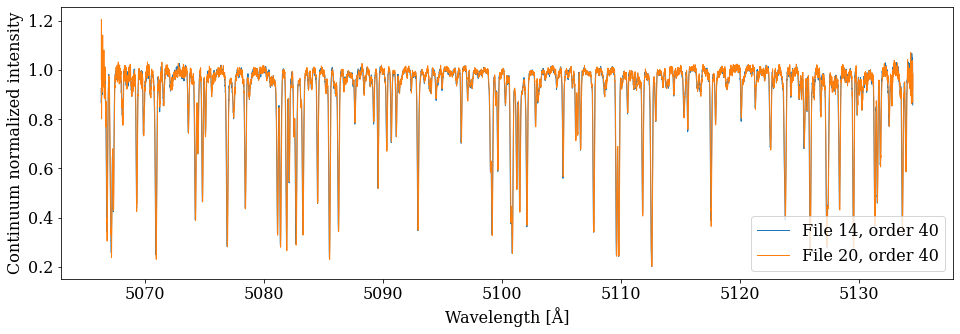

In [21]:
filenames = get_all_spectra_filenames()

def plot_file(file_index, order=40, date=None):
    SPECTRA_DATA = load_spectra_fits(filenames[file_index])
    y1, y1_err, x1 = get_spec_wavel(SPECTRA_DATA, order, continuum_normalized=True, angstrom=True)
    
    if date:
        plt.plot(x1, y1, linewidth=1, label=f"File {file_index}, order {order}, {date}")
    else:
        plt.plot(x1, y1, linewidth=1, label=f"File {file_index}, order {order}")


fig = plt.figure(figsize=(16,5))
plot_file(14)
plot_file(20)
# plt.xlim(5070, 5074)
# plt.xlim(5100, 5500)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Continuum normalized intensity")
plt.legend(loc = "lower right")


### Animate change of peaks over all files



In [ ]:
# from tqdm import tqdm

# dates = get_spectra_dates(filenames)
# for i in tqdm(range(len(filenames))):
#     fig = plt.figure(figsize=(16,5))
#     plot_file(0, dates[0])
#     plot_file(i, dates[i])
#     # plt.xlim(5150, 5400)
#     plt.xlim(5077, 5081)
#     plt.ylim(1, 6)
#     plt.xlabel("Wavelength [Å]")
#     plt.ylabel("Intensity")
#     plt.legend(loc = "lower right")
#     plt.grid()
#     plt.savefig(f"figures/shift_wavel_dates/file_{i}.png", dpi=100, facecolor="white")
#     plt.close(fig) # don't show figure

### Find features

#### Plot features in orders

2813 peaks found


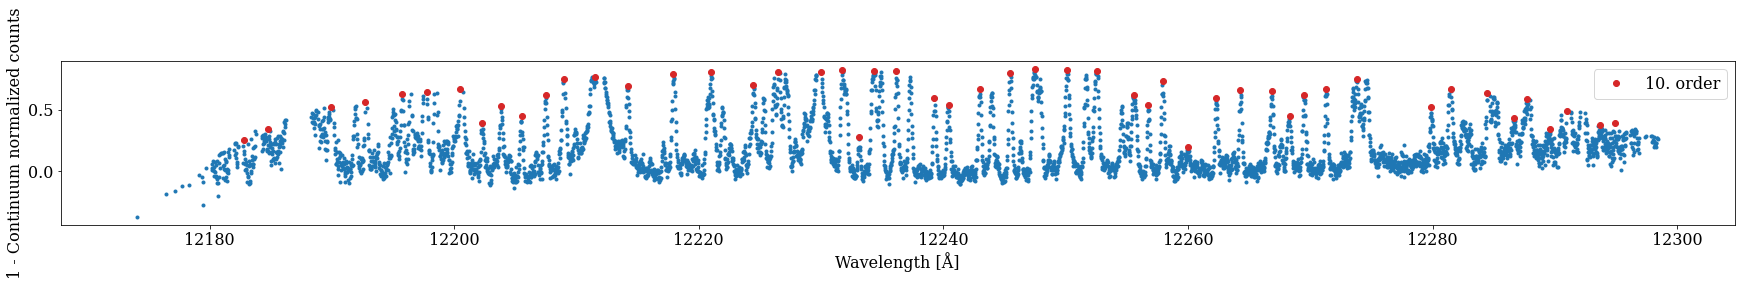

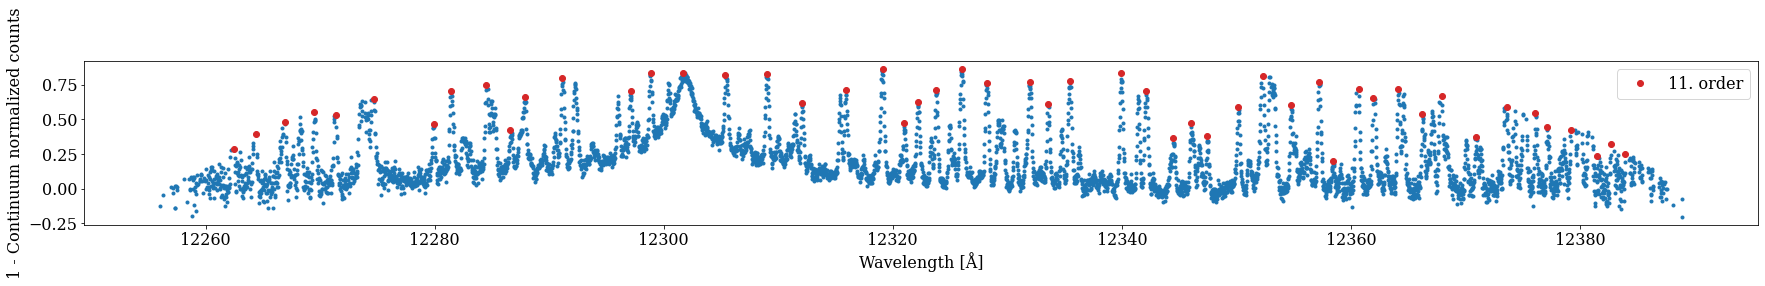

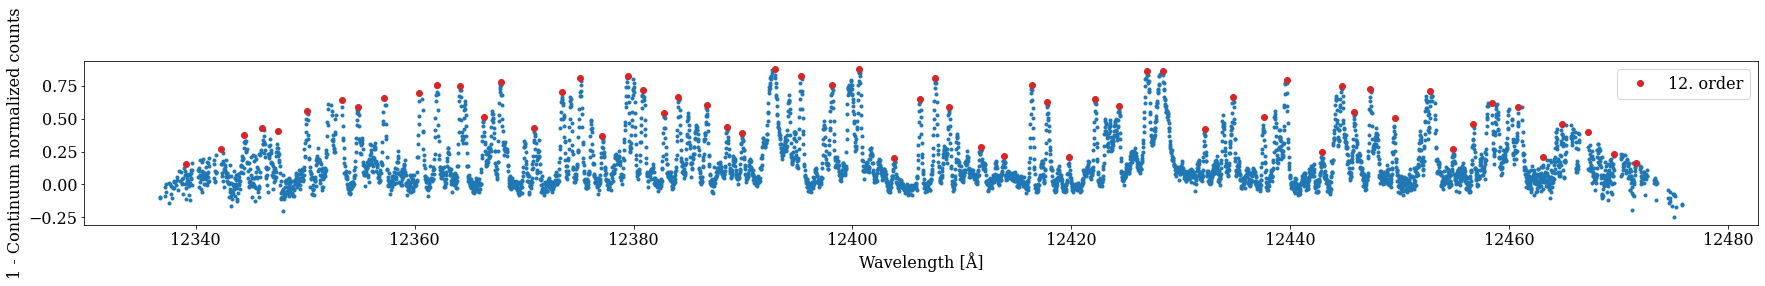

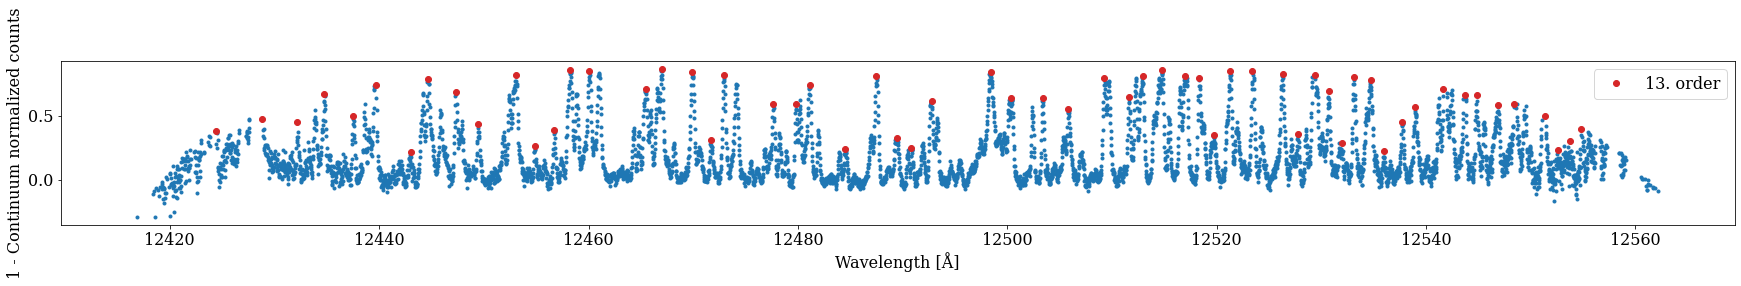

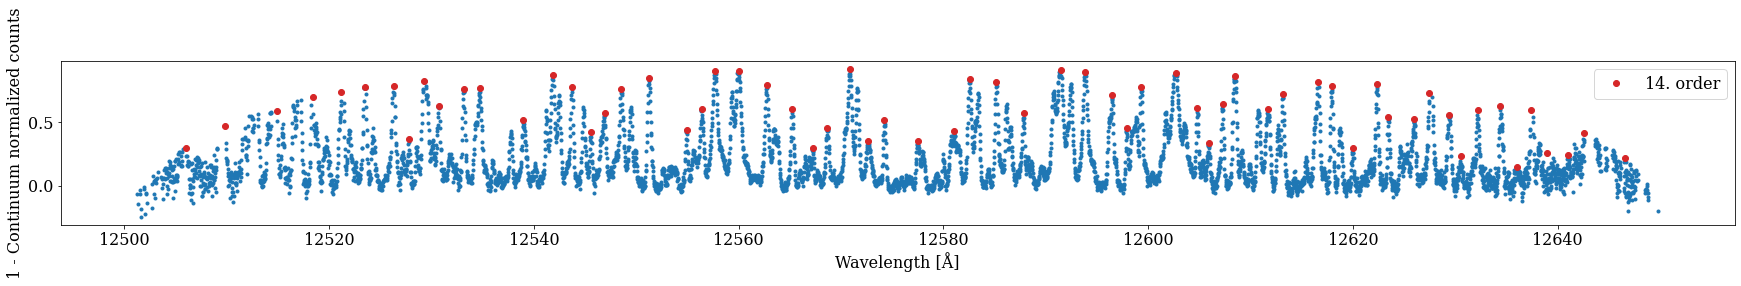

In [35]:
# Plot all orders in one file
filenames = get_spectra_filenames_without_duplicate_dates()[:30]
d1 = find_features(filenames[0], plot_orders=np.arange(10, 15))

#### Plot features in all orders of two files

2813 peaks found
2970 peaks found


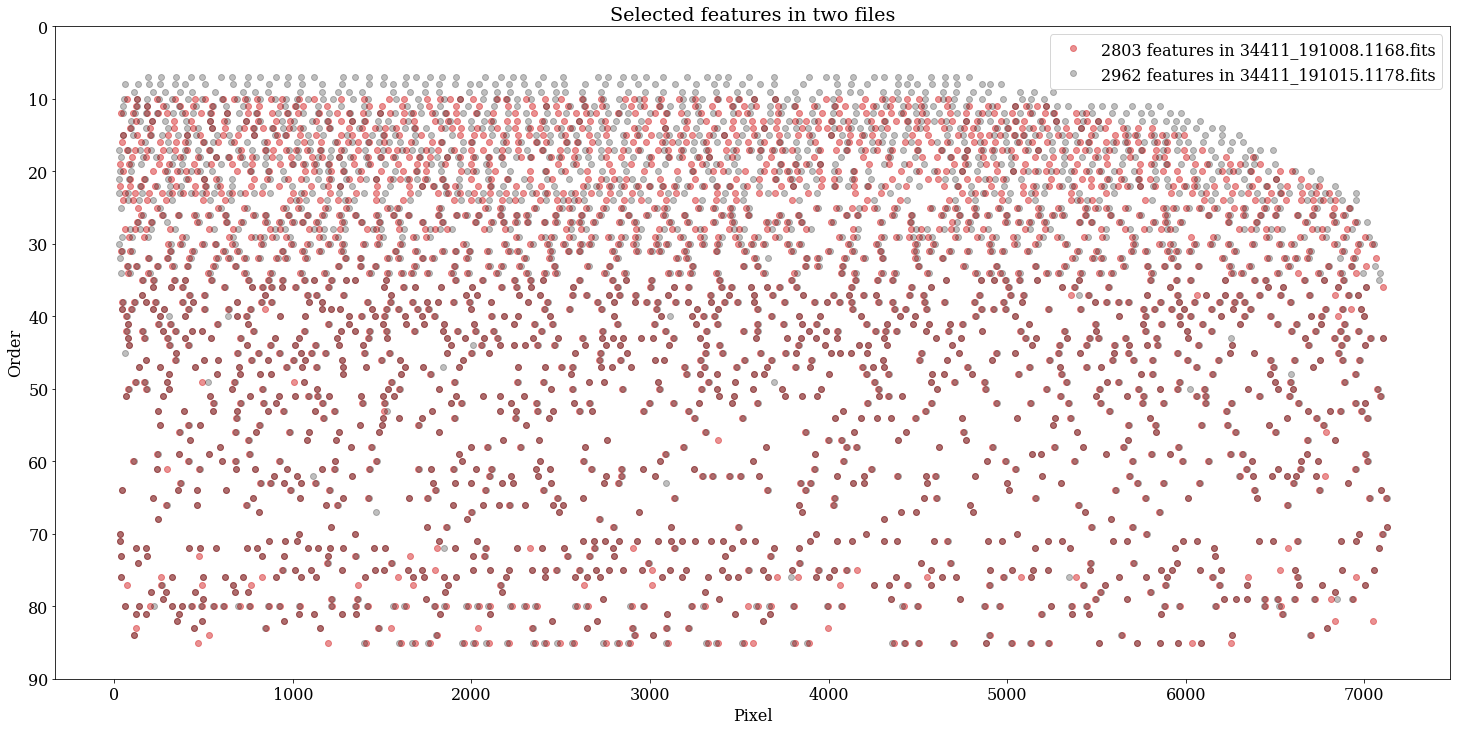

In [36]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[0], filenames[1]
d1 = find_features(file1)
d2 = find_features(file2)

plt.figure(figsize=(25,12))
plt.title(f"Selected features in two files")
x1, y1, x2, y2 = d1[:, 4], d1[:, 5], d2[:, 4], d2[:, 5]
plt.plot(x1, y1, "o", label=f"{len(d1)} features in {file1}", alpha=0.5, color="C3")
plt.plot(x2, y2, "o", label=f"{len(d2)} features in {file2}", alpha=0.25, color="k")
plt.xlabel("Pixel")
plt.ylabel("Order")
plt.ylim(0, 90)
plt.gca().invert_yaxis()
plt.legend()

#### Find matching peaks

In [38]:
filenames = get_spectra_filenames_without_duplicate_dates()
_ = find_feature_matches(find_features(filenames[0]), find_features(filenames[1]), relative_tolerance=0.0008)

2813 peaks found
2970 peaks found
113 matches found


#### Plot number of matches a function of relative tolerance

In [39]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[0], filenames[10]

tolerances = np.linspace(0.00001, 0.001, 50)

num_matches = []
for tol in tolerances:
    matches = find_feature_matches(find_features(file1, log=False), find_features(file2, log=False), filter=True, log=False, relative_tolerance=tol)
    num_matches.append(len(matches))

Text(0.5, 0, 'Relative tolerance')

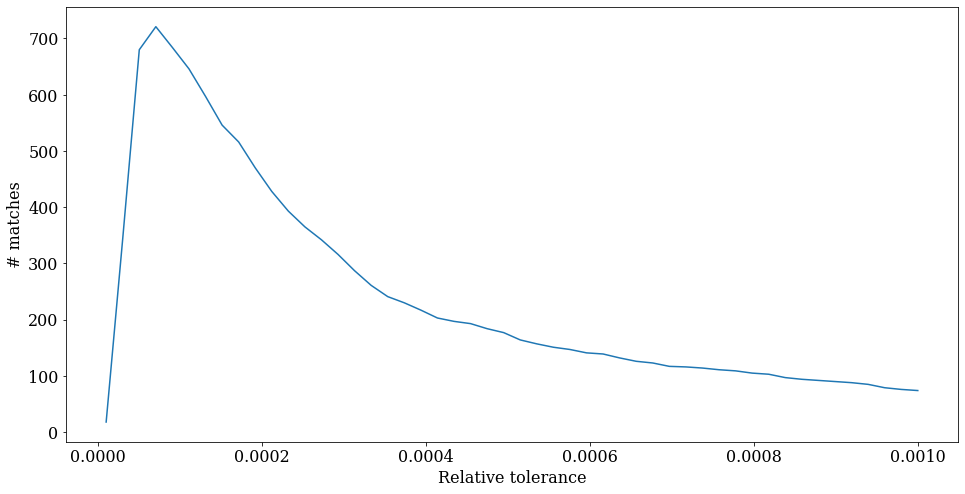

In [40]:
plt.figure(figsize=(16,8))
plt.plot(tolerances, num_matches)
plt.ylabel("# matches")
plt.xlabel("Relative tolerance")

In [ ]:
# # Compare with many files:
# plt.figure(figsize=(16,8))
# plt.ylabel("# matches")
# plt.xlabel("Relative tolerance")
# tolerances = np.linspace(0.000005, 0.003, 20)
# filenames = get_spectra_filenames_without_duplicate_dates()

# file1 = filenames[0]
# f1 = find_features(file1, log=False)

# for i in tqdm(np.arange(1, 10)):
#     file2 = filenames[i]
#     num_matches = []
#     for tol in tolerances:
#         matches = find_feature_matches(f1, find_features(file2, log=False), filter=True, log=False, relative_tolerance=tol)
#         num_matches.append(len(matches))
#     plt.plot(tolerances, num_matches, label=f"0-{i}")

# plt.legend()

#### Plot a matrix of number of returned matches for a given tolerance


In [42]:
filenames = get_spectra_filenames_without_duplicate_dates()
size = len(filenames)
match_matrix = make_nan_matrix(size)

# It takes 15 seconds to find features in all files
features = [find_features(filename, log=False) for filename in filenames]

for x in tqdm(np.arange(size)):
    for y in np.arange(x, size):
        matches = find_feature_matches(features[x], features[y], log=False, relative_tolerance=0.0009)
        match_matrix[x, y] = len(matches)


In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
fig, ax1 = plt.subplots(figsize=(10,10))
cs = ax1.imshow(match_matrix)
cax = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax1, cax=cax)
size = len(match_matrix)
ax1.hlines(y=np.arange(0, size)+0.5, xmin=np.full(size, 0)-0.5, xmax=np.full(size, size)-0.5, color="black", alpha=0.2)
ax1.vlines(x=np.arange(0, size)+0.5, ymin=np.full(size, 0)-0.5, ymax=np.full(size, size)-0.5, color="black", alpha=0.2)
ax1.set_title("Number of matches for relative tolerance = 0.0009")

#### Illustrate the match selection

In [43]:
def plot_matches(matches):

    height = 1
    while height * 10 < len(matches):
        height += 1

    assert height < 100, "Height is higher than 100"

    # Plot matches
    fig, axs = plt.subplots(nrows=height, ncols=10, figsize=(10 * 2.5, height * 2))
    for k in np.arange(len(matches)):
        f1 = matches[k][0]
        f2 = matches[k][1]

        if k > len(axs.flat):
            break

        ax = axs.flat[k]

        wavel1 = f1[0]
        spec1 = f1[1]
        peak1 = f1[3]
        wavel2 = f2[0]
        spec2 = f2[1]
        peak2 = f2[3]

        # Plot difference
        # ax.plot(wavel1, spec1-spec2, color="k")

        # Plot
        ax.plot(wavel1, spec1, color="C0")
        ax.vlines(peak1, 0, 1, linestyle="dashed", color="C0")
        ax.plot(wavel2, spec2, color="C3")
        ax.vlines(peak2, 0, 1, linestyle="dashed", color="C3")

        # Plot peak difference
        diff = peak1 - peak2
        diff = np.round(diff, 3)
        ax.text(0.25, 0.8, diff, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        if np.isclose(np.sum(spec1), np.sum(spec2), 0.1):
            ax.set_facecolor('honeydew')


    # Remove ticks
    for ax in axs.flat:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

2852 peaks found
2890 peaks found
114 matches found


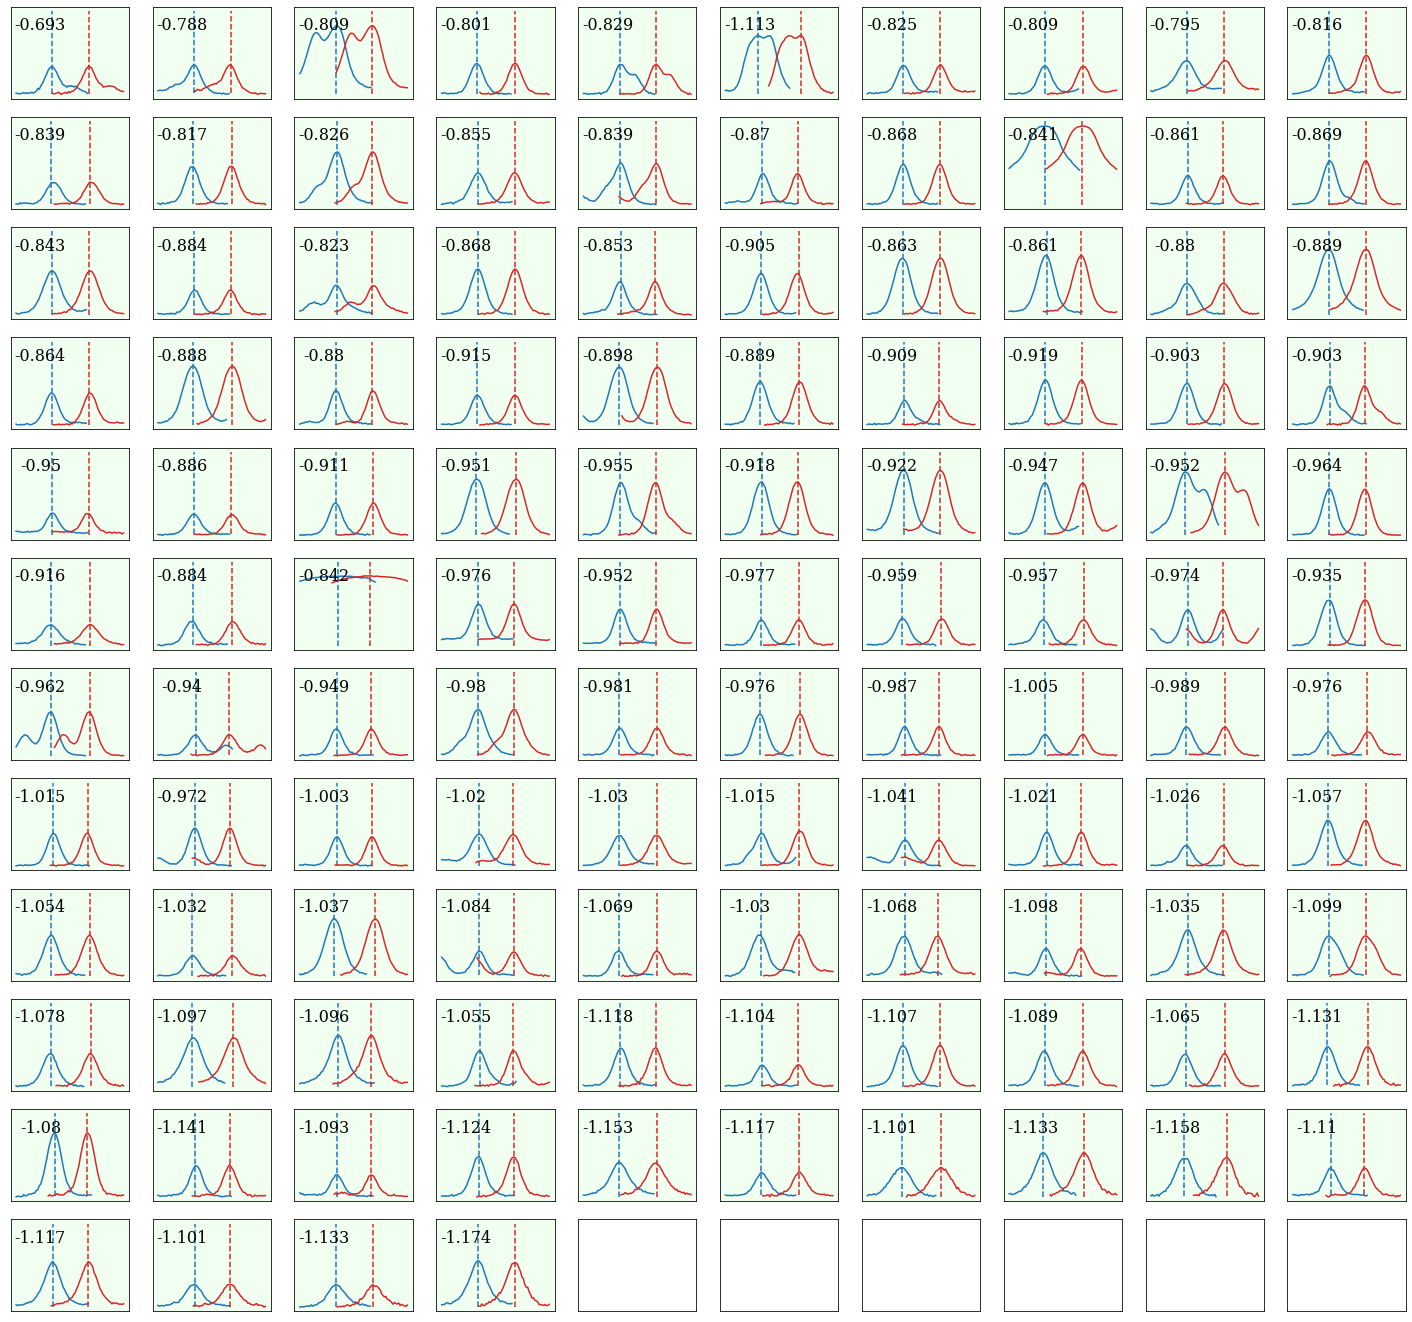

In [44]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[12], filenames[15]
matches = find_feature_matches(find_features(file1), find_features(file2), filter=True, relative_tolerance=0.0007)
plot_matches(matches)

In [ ]:
# shifts = compute_all_feature_shifts(matches)
# plot_features_shift(shifts)

### Do template fitting for features

2970 peaks found
2676 peaks found
111 matches found
12
0 / 111 fits failed


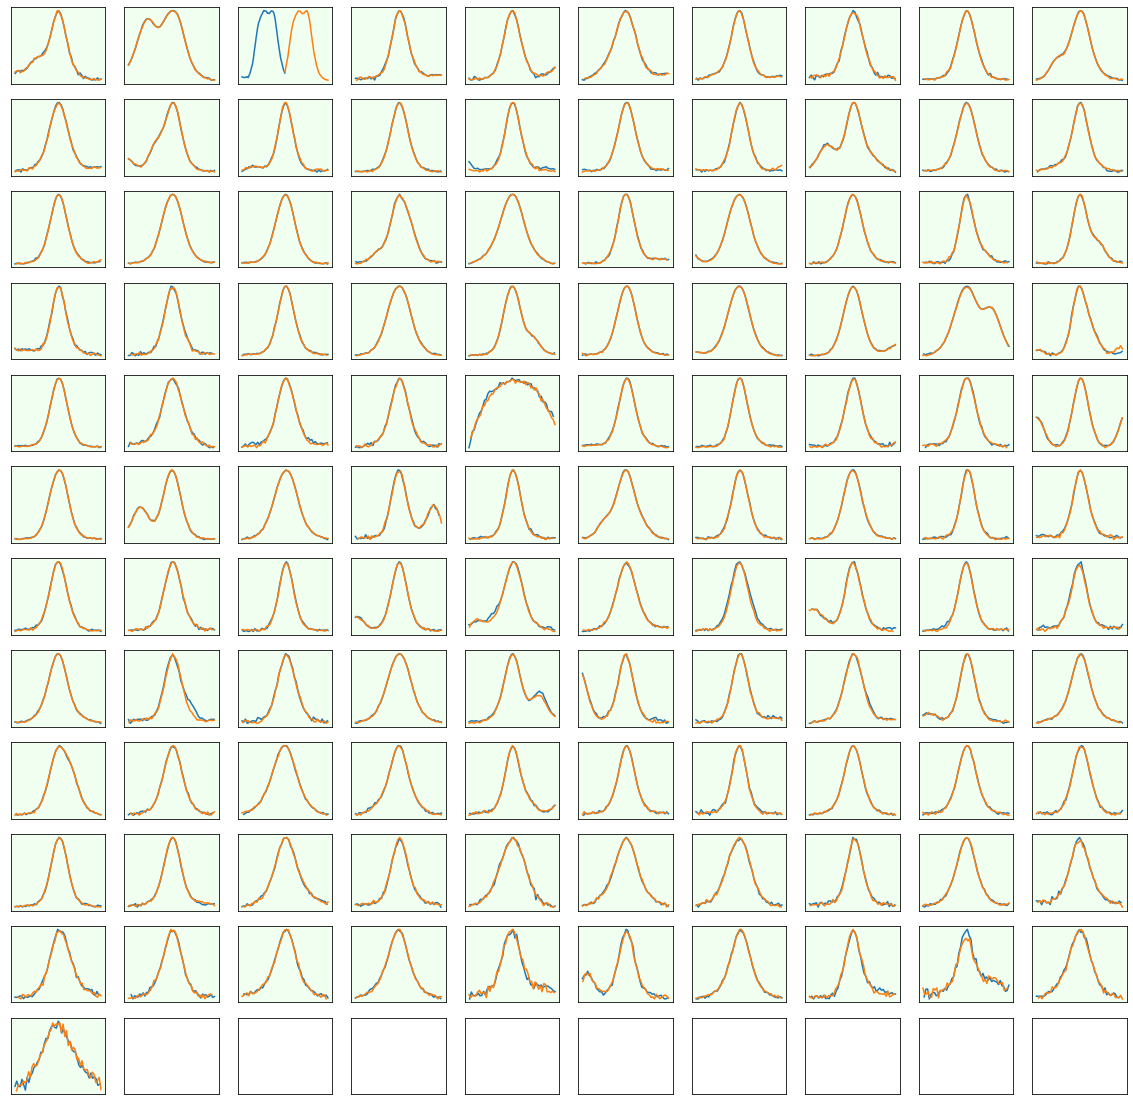

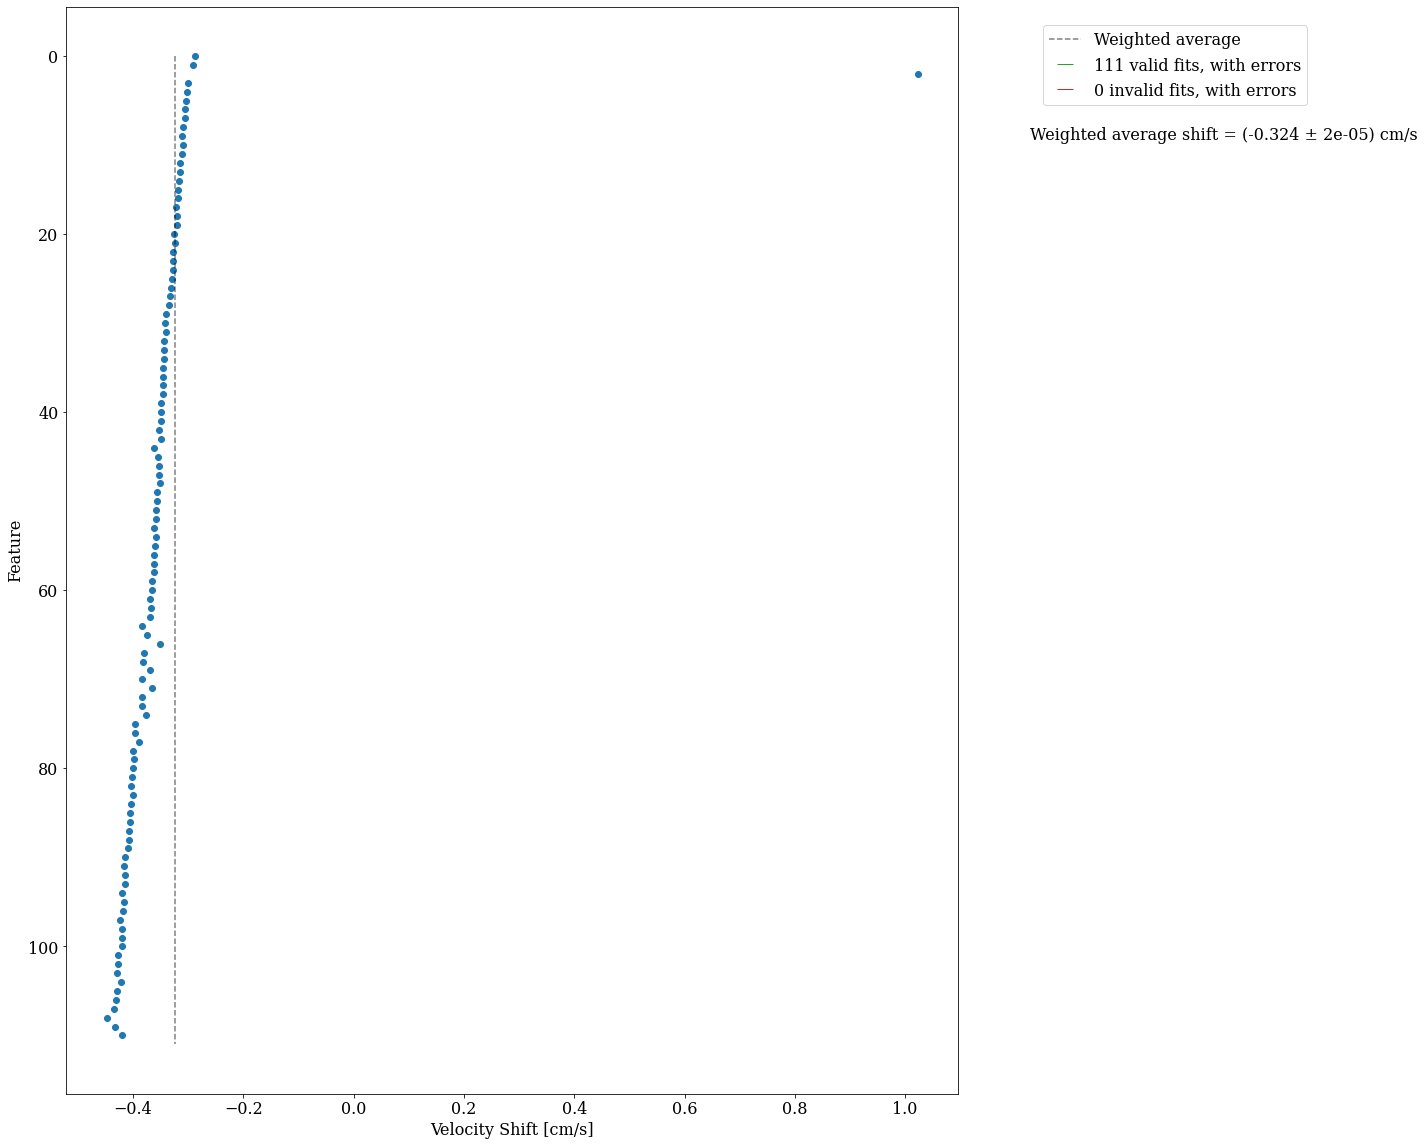

In [124]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[1], filenames[8]
matches = find_feature_matches(find_features(file1), find_features(file2))

# Compute how many rows we need to display all
height = 1
while 10 * height < len(matches):
    height += 1
assert (height < 100), "Height is more than 100"

print(height)

# Compute a plot shifts
fig, axs = plt.subplots(height, 10, figsize=(20, 20))
shifts = compute_all_feature_shifts(matches, plot=True, ax=axs.flat)

# Remove ticks
for ax in axs.flat:
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])


# Plot shift values
plot_features_shift(shifts)

#### Remove outlines with IQR (Interquartile Range) method. 
Here remove values outside of the 25% - 75% range.

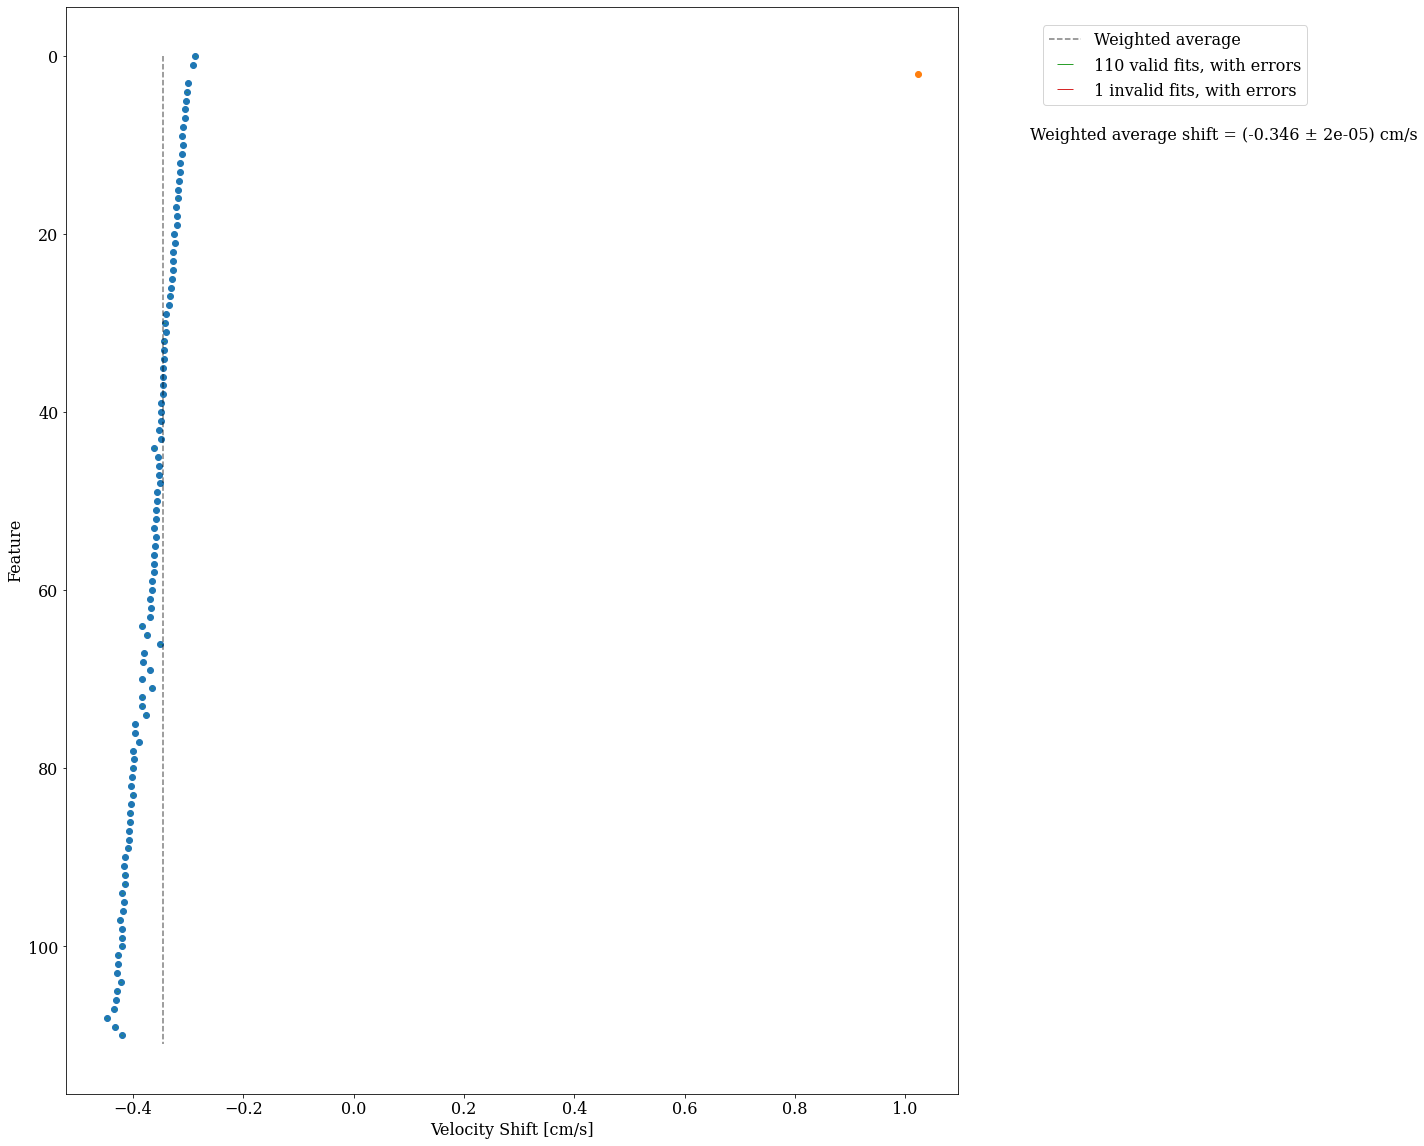

In [125]:
q25 = np.percentile(shifts[:, 0], 25, interpolation='midpoint')
q75 = np.percentile(shifts[:, 0], 75, interpolation='midpoint')
intr_qr = q75-q25
vmin = q25-(1.5*intr_qr)
vmax = q75+(1.5*intr_qr)

df = pd.DataFrame(shifts, copy=True)
df.columns = ["x", "err", "valid"]
df.valid[df.x < vmin] = 0 
df.valid[df.x > vmax] = 0 
n = np.asarray(df)
plot_features_shift(n)


## The Matrix with features

In [111]:
# Try with the one for all orders
filenames = get_spectra_filenames_without_duplicate_dates()[:10]
size = len(filenames)
diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

# It takes 15 seconds to find features in all files
features = [find_features(filename, log=False) for filename in filenames]

for x in tqdm(np.arange(size)):
    for y in np.arange(x, size):
        matches = find_feature_matches(features[x], features[y], log=False)
        shifts = compute_all_feature_shifts(matches[:20], log=False)

        # Remove outliers
        shifts = filter_IQR(shifts)

        # Compute weighted average
        shifts_list, shifts_err_list, shifts_valid_list = shifts[:, 0], shifts[:, 1], shifts[:, 2]
        shift_mean, shift_mean_err = weighted_mean(shifts_list, shifts_err_list)

        # Compute valid ratio, number of succesfull fits / total number of fits
        valid_ratio = len(shifts_valid_list[shifts_valid_list == 1])/len(shifts_valid_list)

        diff_matrix[x, y] = shift_mean
        diff_matrix_err[x, y] = shift_mean_err
        diff_matrix_valid[x, y] = valid_ratio

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


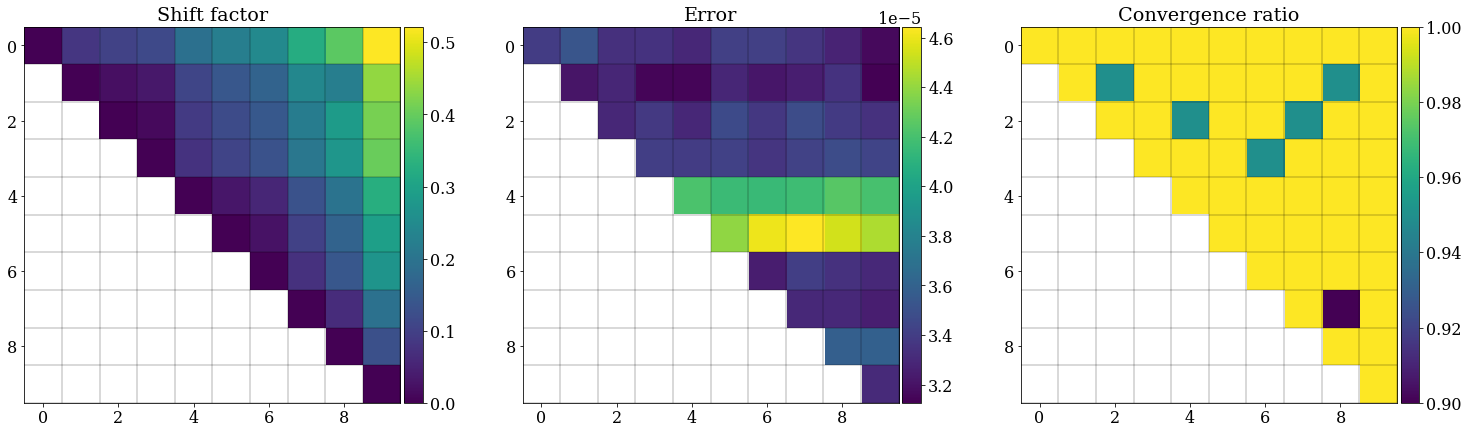

In [112]:
plot_matrix(diff_matrix, diff_matrix_err, diff_matrix_valid)

### Multi-core

**Old times scores:**
- 43m for 30 files, 5th feature, on 6 processes. 
- 1m20 for 5 files, 5th feature, on 6 processes. 
- 1m25 for 5 files, 5th feature, on 8 processes. (using efficiency cores)
- 1m53 for 5 files, 5th feature, on 4 processes.
- 6m19 for 5 files, 5th feature, on 1 process.
- One core: all files should take ~71 hours --> Six cores: ~ 15 hours, looks more like 11 hours
- Six cores: only took 8 hours

- So 6 cores is (6*60 + 19)/(60 + 20) = 4.73 times faster than one core. 

In [181]:
a = []
for filename in tqdm(filenames):
    a.append(find_features(filename, log=False))

 14%|█▍        | 8/58 [00:28<02:55,  3.51s/it]


Process ForkPoolWorker-101:
Process ForkPoolWorker-103:
Process ForkPoolWorker-102:
Process ForkPoolWorker-100:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, 

KeyboardInterrupt: 

In [170]:
# if __name__ == '__main__':
#     result, coords = compute_matrix_multi_core(N_files = -1)
#     np.save("lily_data_results/58x58_all_features_fixed3", [result, coords])
#     # plot_matrix(*parse_matrix_results(result, coords))

N_files = -1
N_processes = 6

# Get list of files and find all features
filenames = get_spectra_filenames_without_duplicate_dates()
if N_files != -1:
    assert N_files > 0, "N_files is negative or zero"
    assert N_files <= len(filenames), "N_files is longer than number of data files"
    filenames = filenames[:N_files]

features = [find_features(filename, log=False) for filename in filenames]

print(len(features))

# Setup coords
size = len(filenames)
# diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

# Compute one list of coords
coords = []
for x in np.arange(size):
    for y in np.arange(x, size):
        if x != y:
            coords.append((x, y)) 
        
        
# Define function for each process
def compute_shift_for_coords_chunk(coords):
    x = coords[0]
    y = coords[1]
    matches = find_feature_matches(features[x], features[y], log=False)
    shifts = compute_all_feature_shifts(matches, log=False) # TESTING: ONLY RUNNING SOME FEATURES
    return shifts


if __name__ == '__main__':
    pool = multiprocess.Pool(processes = N_processes)
    # result = pool.map(compute_shift_for_coords_chunk, coords) # without tqdm

    # With progress bar
    result = []
    for r in tqdm(pool.imap_unordered(compute_shift_for_coords_chunk, coords), total=len(coords)):
        result.append(r)

    np.save("lily_data_results/58x58_all_features_fixed3", [result, coords])

Process ForkPoolWorker-86:
KeyboardInterrupt
Process ForkPoolWorker-81:
Process ForkPoolWorker-83:
Process ForkPoolWorker-87:
Traceback (most recent call last):
Process ForkPoolWorker-85:
Process ForkPoolWorker-82:
Traceback (most recent call last):
Process ForkPoolWorker-84:
Traceback (most recent call last):
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-80:
  File "/Users/jakobharteg/miniconda3/envs/bs

KeyboardInterrupt: 

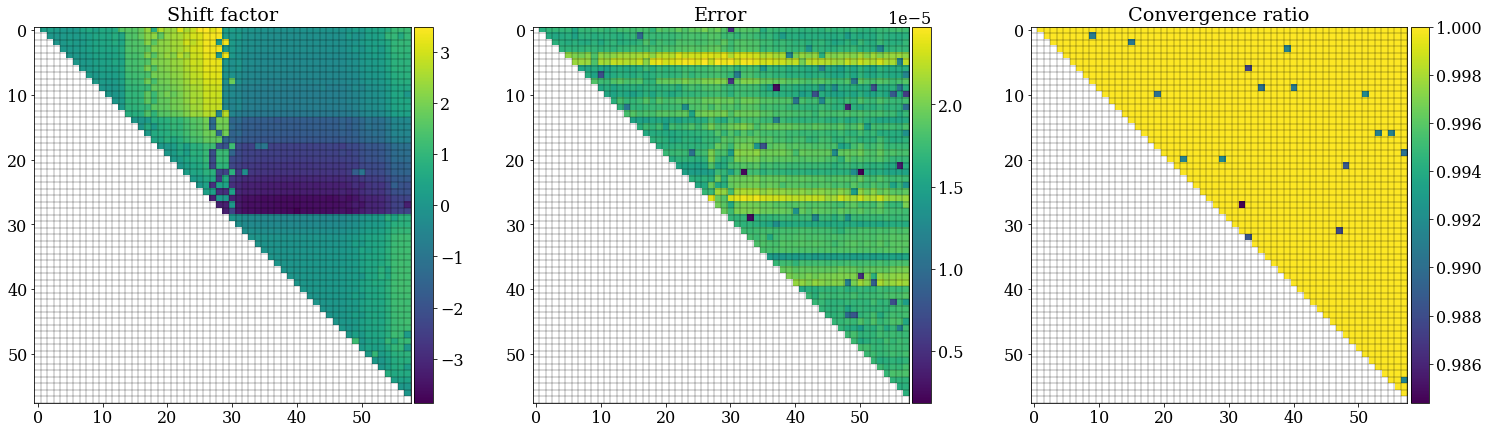

In [65]:
# Reload
result, coords = np.load("lily_data_results/58x58_all_features_fixed2.npy", allow_pickle=True)
plot_matrix(*parse_matrix_results(result, coords))

### Plot feature plots for matrix

In [153]:
filtered_result = []

for file_result in result:
    s = filter_IQR(file_result, set_to_nan=True)
    filtered_result.append(s)

filtered_result = np.asarray(filtered_result, dtype=object)

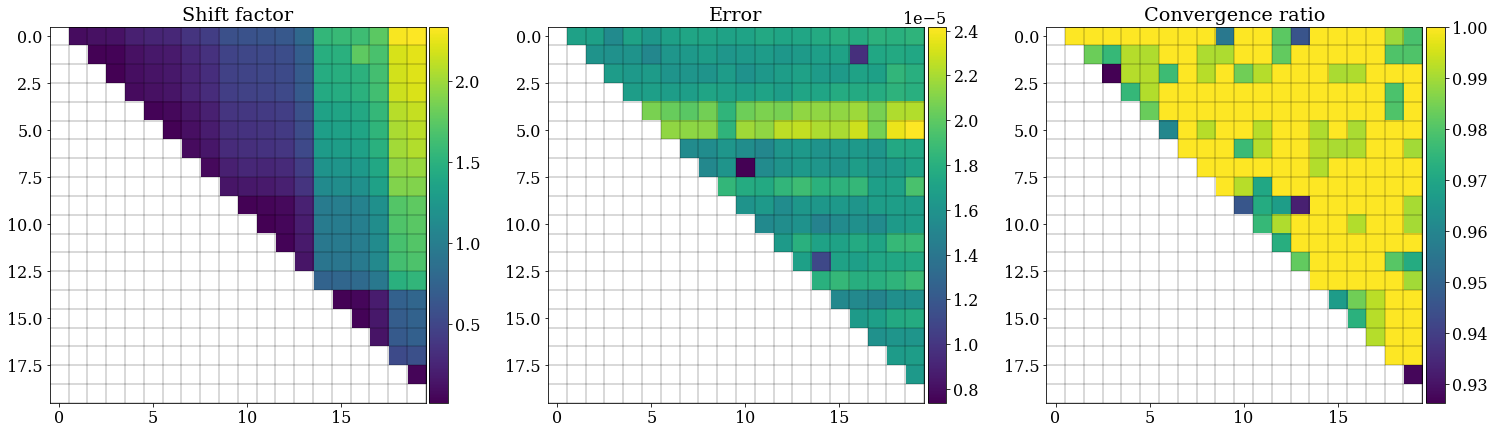

In [167]:
plot_matrix(*parse_matrix_results(filtered_result, coords))

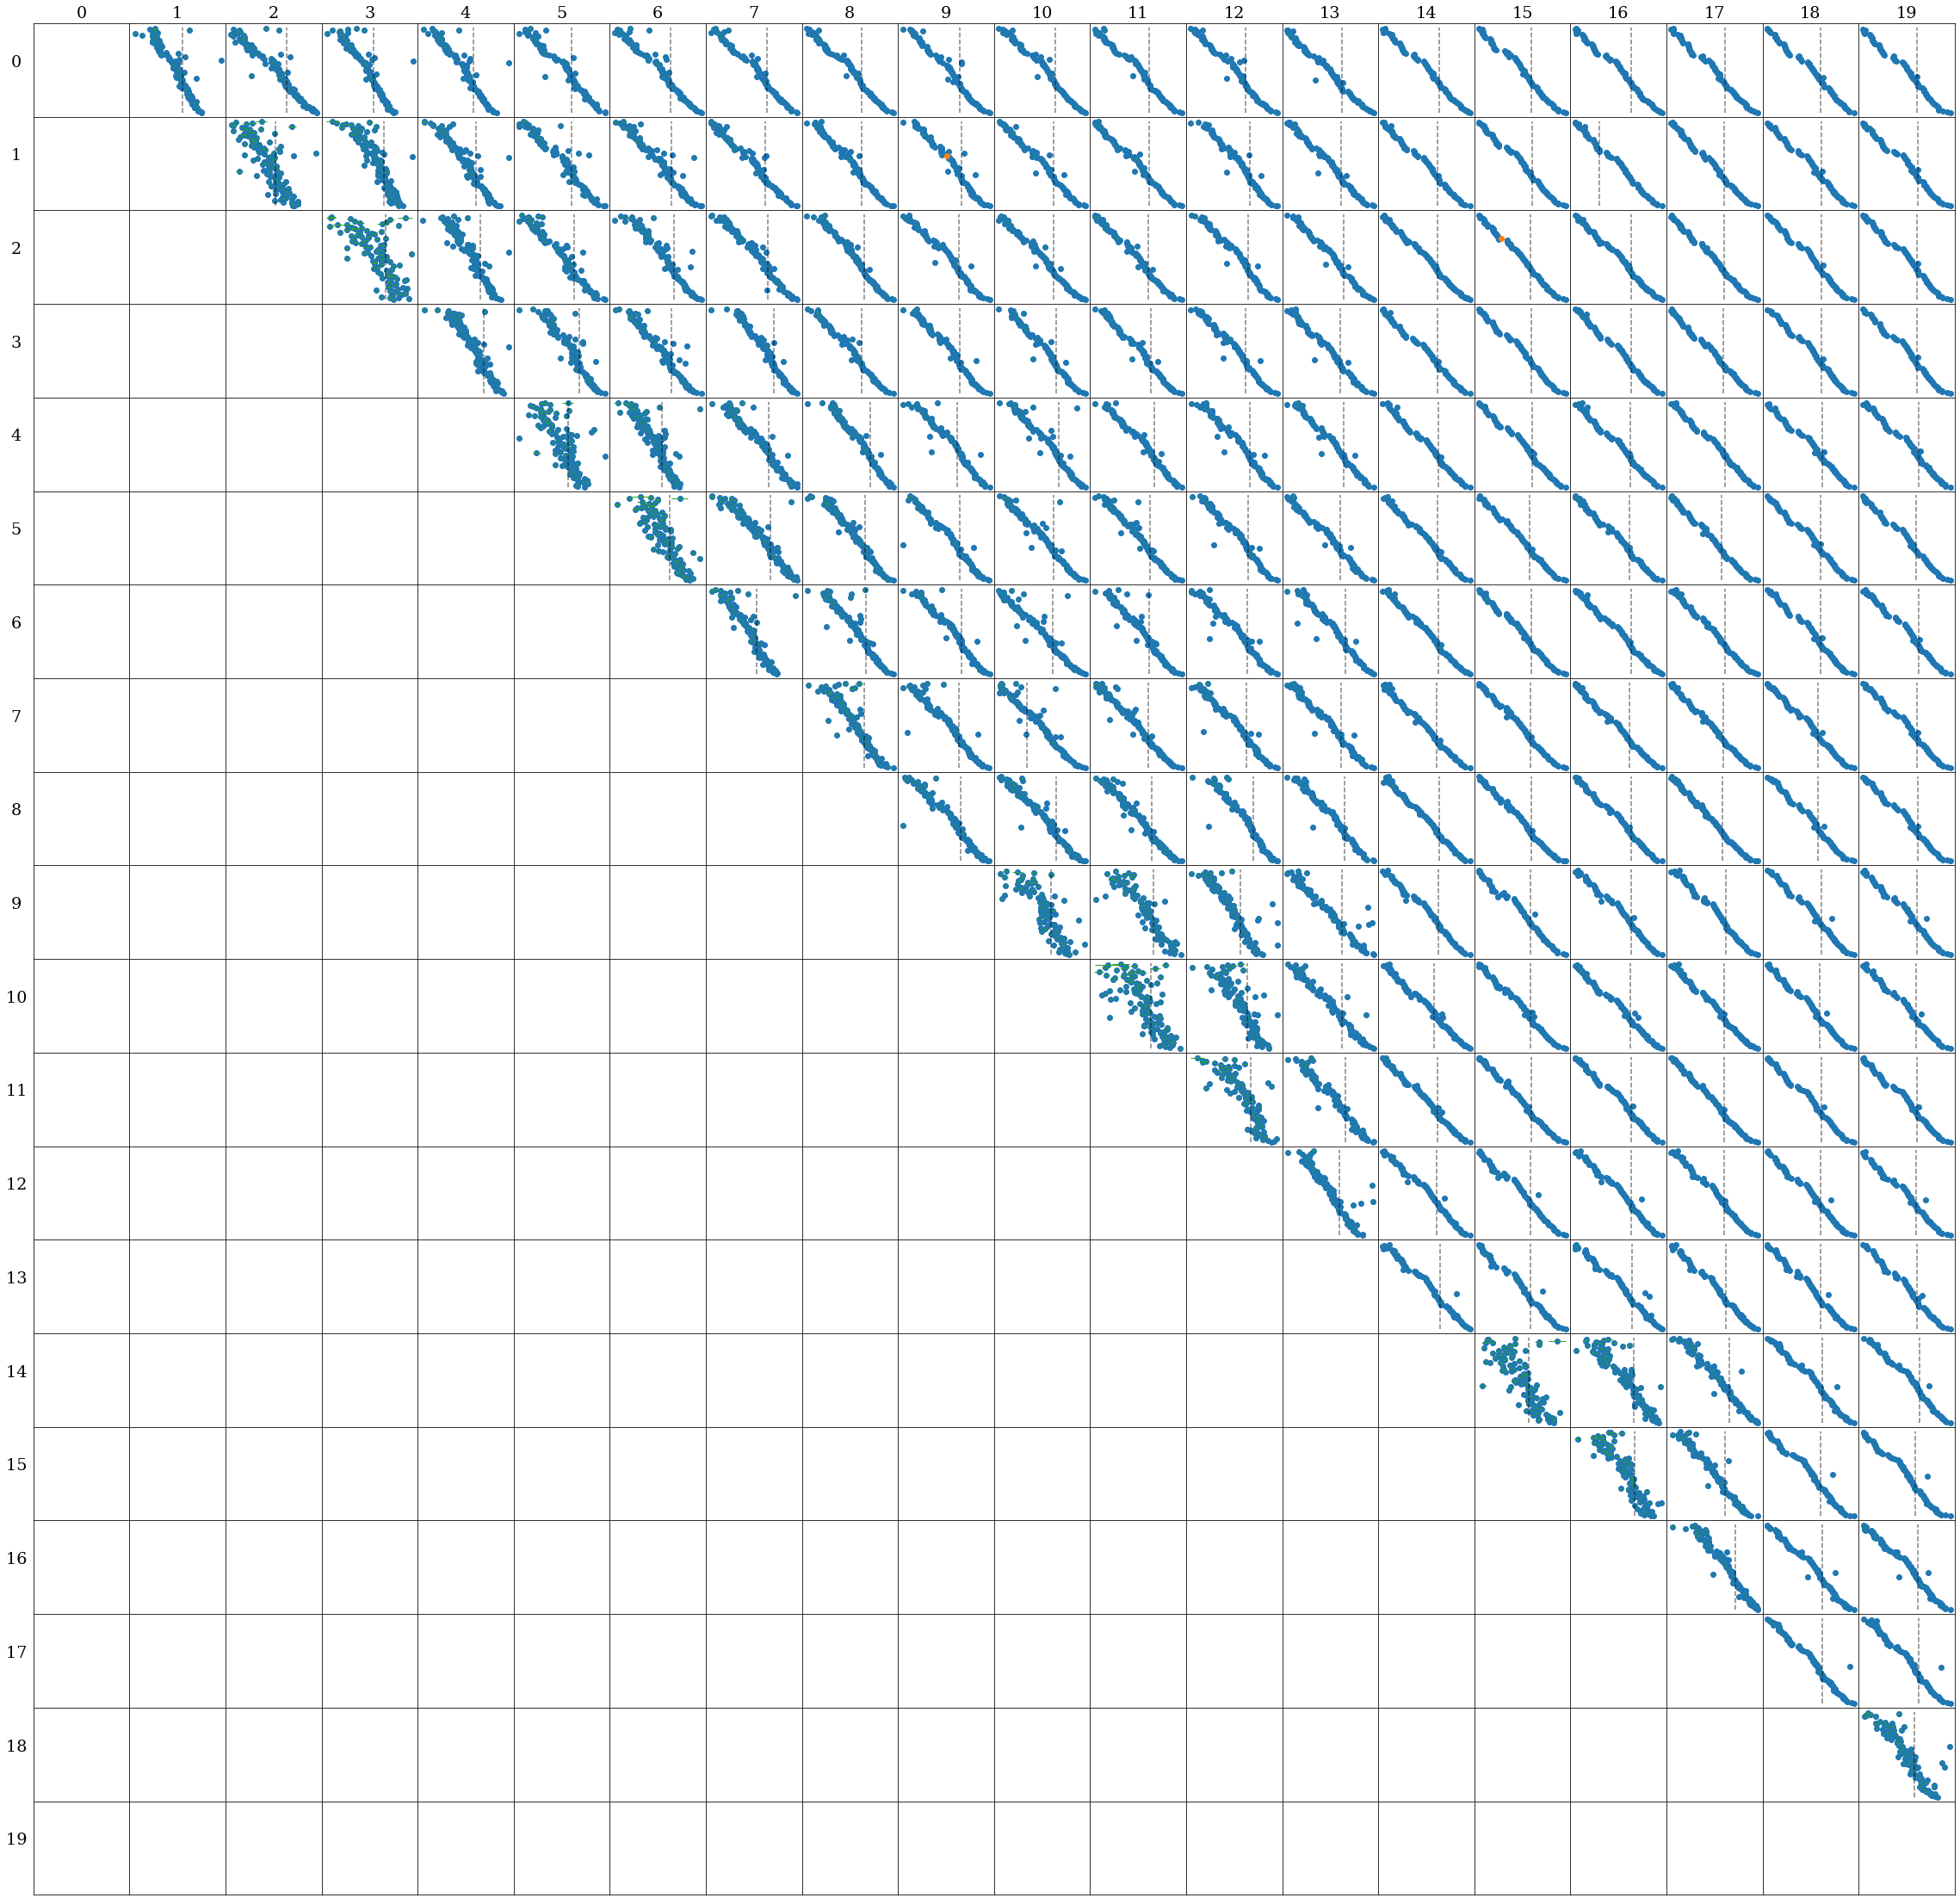

In [158]:
size = np.max(coords) + 1
fig, axs = plt.subplots(size, size, figsize=(40, 40))

# Hide labels on all 
for ax in axs.flat:
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

for x in np.arange(size):
    for y in np.arange(x, size):
        
        # Get index from coords
        try:
            index = list(coords).index((x, y))
            plot_features_shift(filtered_result[index], axs[x, y], labels=False)
        except:
            continue


# Remove space between graphs
plt.subplots_adjust(wspace=0, hspace=0)

# Write column and row numbers
cols = [col for col in range(0, size)]
rows = [row for row in range(0, size)]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(f"{row}     ", rotation=0, size='large')


# plt.savefig(f"figures/58x58_features_fixed2.png", dpi=100)
# plt.close(fig) # don't show figure


### Matrix reduction

#### First: just look at the above diagonal
This is the difference from observation to observation

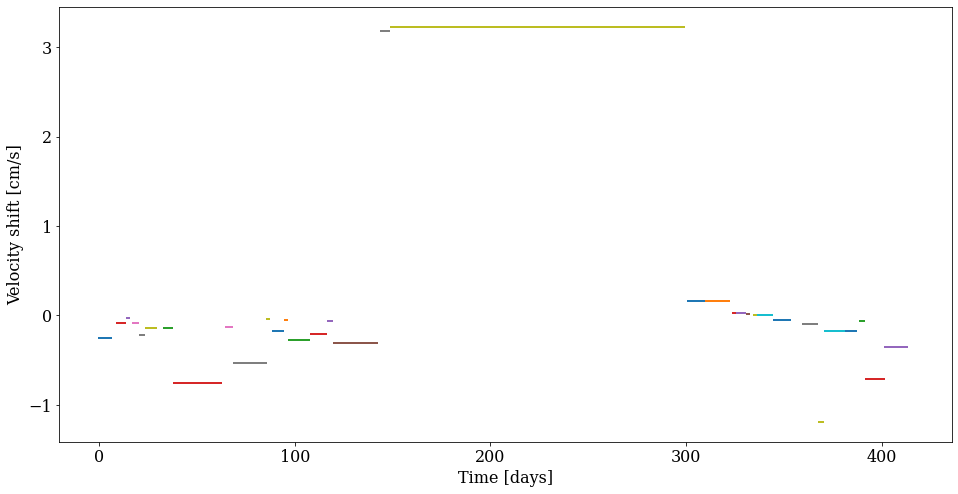

In [81]:
# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
result, coords = np.load("lily_data_results/58x58_all_features_fixed2.npy", allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)
velocity_shifts = get_above_diagonal(diff_matrix)
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
intervals = get_time_interval_between_observations(dates)

plt.figure(figsize=(16, 8))
plt.xlabel("Time [days]")
plt.ylabel("Velocity shift [cm/s]")
for shift, interval in zip(velocity_shifts, intervals):
    # print(shift, np.diff(interval), interval)
    days_interval = np.arange(*interval)
    plt.plot(days_interval, [shift] * len(days_interval), linewidth=2)


#### Now the matrix reduction using chi2

In [82]:
result, coords = np.load("lily_data_results/58x58_all_features_fixed2.npy", allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)

def model_chi2(*V):
    V = np.asarray([*V])
    res = []
    size = diff_matrix.shape[0] 
    # V = np.ones(size)
    for x in np.arange(size):
        for y in np.arange(x, size - 1):
            if x != y:
                diff_matrix[x, y]
                V[x]
                V[y]
                res.append(((diff_matrix[x, y] - (V[x] - V[y])) / diff_matrix_err[x, y])**2)
    chi2 = np.sum(res)
    return chi2
model_chi2.errordef = 1

# Use the above diagonal as init values
init_values = get_above_diagonal(diff_matrix)

minuit = Minuit(model_chi2, *init_values)
minuit.migrad()

/Users/jakobharteg/GitHub/bachelor-project/radial_velocity_functions.py:516: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.39e+12                   │             Nfcn = 1731              │
│ EDM = 0.00106 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │-724.5176e-3│ 0.0022e-3 │            │            │         │         │       │
│ 1 │ x1   │-717.8826e-3│ 0.0022e-3 │            │            │         │         │       │
│ 2 │ x2   │-681.1313e-3│ 0.0023e-3 │            │            │         │         │       │
│ 3 │ x3   │-666.5371e-3│ 0.0023e-3 │            │            │         │         │       │
│ 4 │ x4   │-588.0772e-3│ 0.0027e-3 │            │            │         │         │       │
│ 5 │ x5   │-557.0070e-3│ 0.0029e-3 │            │            │         │         │       │
│ 6 │ x6   │-529.8107e-3│ 0.0022e-3 │            │            │         │         │       │
│ 7 │ x7   │-447.9189e-3│ 0.0021e-3 │            │            │         │         │       │
│ 8 │ x8   │-640.3088e-3│ 0.0023e-3 │            │            │         │         │       │
│ 9 │ x9   │-255.7605e-3│ 0.0018e-3 │            │            │         │         │       │
│ 10│ x10  │-199.3961e-3│ 0.0020e-3 │            │            │         │         │       │
│ 11│ x11  │-182.2770e-3│ 0.0023e-3 │            │            │         │         │       │
│ 12│ x12  │-143.1998e-3│ 0.0020e-3 │            │            │         │         │       │
│ 13│ x13  │ -32.0e-6  │  2.4e-6   │            │            │         │         │       │
│ 14│ x14  │742.5924e-3│ 0.0022e-3 │            │            │         │         │       │
│ 15│ x15  │762.7754e-3│ 0.0024e-3 │            │            │         │         │       │
│ 16│ x16  │814.1942e-3│ 0.0023e-3 │            │            │         │         │       │
│ 17│ x17  │ 1.0262040 │ 0.0000023 │            │            │         │         │       │
│ 18│ x18  │ 1.2204651 │ 0.0000022 │            │            │         │         │       │
│ 19│ x19  │ 1.4899529 │ 0.0000024 │            │            │         │         │       │
│ 20│ x20  │ 1.5672877 │ 0.0000024 │            │            │         │         │       │
│ 21│ x21  │ 1.7583363 │ 0.0000020 │            │            │         │         │       │
│ 22│ x22  │856.2856e-3│ 0.0015e-3 │            │            │         │         │       │
│ 23│ x23  │ 2.0391223 │ 0.0000024 │            │            │         │         │       │
│ 24│ x24  │ 2.2610168 │ 0.0000024 │            │            │         │         │       │
│ 25│ x25  │ 2.3164888 │ 0.0000025 │            │            │         │         │       │
│ 26│ x26  │ 2.6271059 │ 0.0000027 │            │            │         │         │       │
│ 27│ x27  │ 2.2924615 │ 0.0000025 │            │            │         │         │       │
│ 28│ x28  │ 2.2180899 │ 0.0000025 │            │            │         │         │       │
│ 29│ x29  │-48.1097e-3│ 0.0020e-3 │            │            │         │         │       │
│ 30│ x30  │-114.0888e-3│ 0.0020e-3 │            │            │         

In [83]:
# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
result, coords = np.load("lily_data_results/58x58_all_features.npy", allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)
velocity_shifts = get_above_diagonal(diff_matrix)
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
intervals = get_time_interval_between_observations(dates)

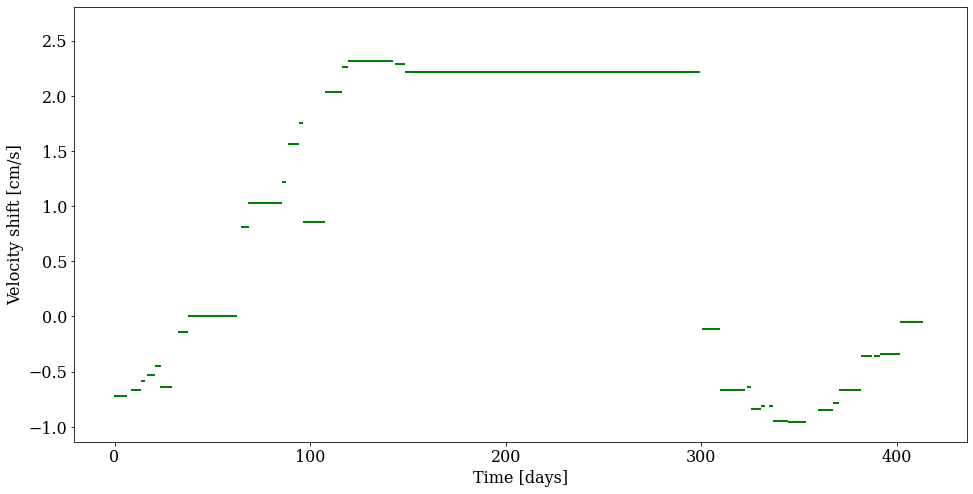

In [89]:
fig = plt.figure(figsize=(16, 8))
plt.xlabel("Time [days]")
plt.ylabel("Velocity shift [cm/s]")

# Plot matrix reduction results
for shift, interval in zip(minuit.values[:], intervals):
    # print(shift, np.diff(interval), interval)
    days_interval = np.arange(*interval)
    plt.plot(days_interval, [shift] * len(days_interval), linewidth=2, color="green")

# Plot above diagonal
# for shift, interval in zip(velocity_shifts, intervals):
#     # print(shift, np.diff(interval), interval)
#     days_interval = np.arange(*interval)
#     plt.plot(days_interval, [shift] * len(days_interval), linewidth=2, color="red")

### UMAP feature selection

In [ ]:
result, coords = np.load("lily_data_results/58x58_all_features.npy", allow_pickle=True)

xshift = []
for r in result[:50]:
    xshift.append(r[:, 0])

xshift = np.concatenate(xshift)

# df = pd.DataFrame(result[1218], copy=True)
# df.columns = ["x", "err", "valid"]

# # Filter larger values
# df.valid[:] = 1 # reset ... 
# df.valid[df.x > 0.25] = 0 
# df.valid[df.x < -0.25] = 0 
# n = np.asarray(df)

import umap
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(df.x)
# embedding.shape

reducer = umap.UMAP(random_state=42)
xshift = xshift.reshape(-1, 1)
reducer.fit(xshift)

umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)


embedding = reducer.transform(xshift)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
# embedding.shape

plt.scatter(embedding[:, 0], embedding[:, 1], c=xshift, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

# # plot_features_shift(n)